In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import anndata as ad
import scanpy as sc
import seaborn as sns
import scanorama

In [3]:
malignant = sc.read_h5ad('/home/data/sdzl14/NSCLC/zong/malignant_integrated.h5ad')
malignant = malignant.copy()
malignant

AnnData object with n_obs × n_vars = 34052 × 17317
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'Celltype_fine', 'cell_type_major', 'tumor_nontumor_finer', 'batch', 'leiden'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Dataset_colors', 'Drug_colors', 'Origin_colors', 'Patient_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
immune = sc.read_h5ad('/home/data/sdzl14/NSCLC/zong/immune.scanvi.h5ad')
immune = immune.copy()
immune

AnnData object with n_obs × n_vars = 594084 × 16813
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'tumor_nontumor_finer', 'minor', 'cell_type', 'celltype_fine', 'immune_celltype', 'immune_celltype_coarse'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'immune_celltype_coarse_colors', 'immune_celltype_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scanvi_fix', 'X_scanvi_fix_linear', 'X_scanvi_no_fix', 'X_scvi', 'X_umap', '_latent'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
# 检查原始类别
print("Original categories in 'Tissue':", malignant.obs['Tissue'].cat.categories)

# 创建一个新的分类列，仅针对'tumor_metastasis'
def create_subcategory(row):
    if row['Tissue'] == 'tumor_metastasis':
        return f"{row['Tissue']}_{row['Origin']}"
    else:
        return row['Tissue']

malignant.obs['SubTissue'] = malignant.obs.apply(create_subcategory, axis=1)

# 将新列转换为categorical类型
malignant.obs['SubTissue'] = pd.Categorical(malignant.obs['SubTissue'])

# 检查新的类别
print("\nNew categories in 'SubTissue':", malignant.obs['SubTissue'].cat.categories)
# 检查原始类别
print("Original categories in 'Tissue':", immune.obs['Tissue'].cat.categories)

# 创建一个新的分类列，仅针对'tumor_metastasis'
def create_subcategory(row):
    if row['Tissue'] == 'tumor_metastasis':
        return f"{row['Tissue']}_{row['Origin']}"
    else:
        return row['Tissue']

immune.obs['SubTissue'] = immune.obs.apply(create_subcategory, axis=1)

# 将新列转换为categorical类型
immune.obs['SubTissue'] = pd.Categorical(immune.obs['SubTissue'])

# 检查新的类别
print("\nNew categories in 'SubTissue':", immune.obs['SubTissue'].cat.categories)


Original categories in 'Tissue': Index(['effusion', 'normal_adjacent', 'normal_distant', 'tumor_edge',
       'tumor_metastasis', 'tumor_middle'],
      dtype='object')

New categories in 'SubTissue': Index(['effusion', 'normal_adjacent', 'normal_distant', 'tumor_edge',
       'tumor_metastasis_adrenal', 'tumor_metastasis_brain',
       'tumor_metastasis_liver', 'tumor_metastasis_lung',
       'tumor_metastasis_lymph_node', 'tumor_metastasis_pleura/effusion',
       'tumor_middle'],
      dtype='object')
Original categories in 'Tissue': Index(['effusion', 'normal_adjacent', 'tumor_edge', 'tumor_metastasis',
       'tumor_middle', 'tumor_primary'],
      dtype='object')

New categories in 'SubTissue': Index(['effusion', 'normal_adjacent', 'tumor_edge', 'tumor_metastasis_adrenal',
       'tumor_metastasis_brain', 'tumor_metastasis_liver',
       'tumor_metastasis_lung', 'tumor_metastasis_lymph_node',
       'tumor_metastasis_pleura/effusion', 'tumor_middle', 'tumor_primary'],
      dtype

In [ ]:
malignant.X = malignant.layers['counts']
# 检查数据分布特征
print("数值类型:", malignant.X.dtype)
print("最大值:", malignant.X.max())
print("典型值示例:", malignant.X[0, :10].toarray().flatten())

# 专用验证函数（需自行实现）
def check_values(arr):
    if np.issubdtype(arr.dtype, np.integer):
        print("✅ 原始 counts 特征（整数值）")
    elif (arr < 20).all():
        print("⚠️ 可能经过 log1p 处理（数值范围压缩）")
        
check_values(malignant.X)

In [12]:
malignant.obs['celltype'] = malignant.obs['SubTissue']
immune.obs['celltype'] = immune.obs['immune_celltype_coarse']

In [13]:
immune.X = immune.layers['counts']
malignant.X = malignant.layers['counts']
adata = immune.concatenate(malignant,join='inner')
adata.X.max()

/tmp/ipykernel_3645002/3734488266.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = immune.concatenate(malignant,join='inner')


37275176.0

In [14]:
adata.obs['celltype'].values.describe()

,counts,freqs
categories,,
AM,44733,0.071215
CD4,189003,0.300895
CD8,70572,0.112351
Cycling B,200,0.000318
Cycling T,5265,0.008382
GC B,790,0.001258
ILC,265,0.000422
Macro,76296,0.121464
Mast,8947,0.014244


In [35]:
adata.obs['celltype'].cat.categories

Index(['AM', 'CD4', 'CD8', 'Cycling B', 'Cycling T', 'GC B', 'ILC', 'Macro',
       'Mast', 'Memory B', 'Mono', 'NK', 'Naive B', 'Neutrophil', 'Pericyte',
       'Plasma', 'Treg', 'cDC1', 'cDC2', 'effusion', 'mregDC',
       'normal_adjacent', 'normal_distant', 'pDC', 'tumor_edge',
       'tumor_metastasis_adrenal', 'tumor_metastasis_brain',
       'tumor_metastasis_liver', 'tumor_metastasis_lung',
       'tumor_metastasis_lymph_node', 'tumor_metastasis_pleura/effusion',
       'tumor_middle'],
      dtype='object')

In [15]:
cat = ['AM', 'CD4', 'CD8', 'Cycling B', 'Cycling T', 'GC B', 'ILC', 'Macro',
       'Mast', 'Memory B', 'Mono', 'NK', 'Naive B', 'Neutrophil', 'Pericyte',
       'Plasma', 'Treg', 'cDC1', 'cDC2', 'effusion', 'mregDC',
       'normal_adjacent', 'pDC', 'tumor_edge',
       'tumor_metastasis_adrenal', 'tumor_metastasis_brain',
       'tumor_metastasis_liver',
       'tumor_metastasis_lymph_node', 'tumor_metastasis_pleura/effusion',
       'tumor_middle']
adata = adata[adata.obs['celltype'].isin(cat)]

In [16]:
adata.obs['celltype'].cat.categories

Index(['AM', 'CD4', 'CD8', 'Cycling B', 'Cycling T', 'GC B', 'ILC', 'Macro',
       'Mast', 'Memory B', 'Mono', 'NK', 'Naive B', 'Neutrophil', 'Pericyte',
       'Plasma', 'Treg', 'cDC1', 'cDC2', 'effusion', 'mregDC',
       'normal_adjacent', 'pDC', 'tumor_edge', 'tumor_metastasis_adrenal',
       'tumor_metastasis_brain', 'tumor_metastasis_liver',
       'tumor_metastasis_lymph_node', 'tumor_metastasis_pleura/effusion',
       'tumor_middle'],
      dtype='object')

In [18]:
adata.obs['SubTissue'].value_counts()

SubTissue
tumor_primary                       196760
tumor_metastasis_adrenal            137073
normal_adjacent                     127694
tumor_metastasis_brain               60508
tumor_metastasis_lymph_node          31869
tumor_edge                           26170
tumor_middle                         20426
effusion                             18333
tumor_metastasis_lung                 3144
tumor_metastasis_pleura/effusion      2969
tumor_metastasis_liver                2116
Name: count, dtype: int64

In [20]:
tumor_middle = adata[adata.obs['SubTissue'] == 'tumor_middle']
# 确保使用原始counts数据（假设原始counts存储在layers['counts']）
tumor_middle.X = tumor_middle.layers['counts'].copy()  # 恢复原始counts到X
# 检查基因标识符类型（假设使用基因符号）
print(tumor_middle.obs.head(3))  # 确认gene_id列名（需为hgnc_symbol或ensembl）
# 保存为h5ad文件（默认使用ensembl ID，若用symbol需标注）
counts_path = "/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/adata.h5ad"
adata.write(counts_path)
df_meta = pd.DataFrame(data={'Cell':list(tumor_middle.obs.index),
                             'cell_type':[ i for i in tumor_middle.obs['celltype']]
                            })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/meta.tsv', sep = '\t')

import pandas as pd
from scipy import stats
# 设置对比分组依据（假设使用粗粒度分类'spatial_celltype_coarse'）
groupby_column = 'celltype'

# 执行差异分析
sc.pp.normalize_total(tumor_middle, target_sum=1e4)
sc.pp.log1p(tumor_middle)
sc.pp.highly_variable_genes(
    tumor_middle,
    flavor="seurat",
    n_top_genes=2000,

    inplace=True,batch_key="Dataset")

sc.pp.scale(tumor_middle, max_value=10)


sc.tl.rank_genes_groups(
    tumor_middle,
    groupby=groupby_column,
    method='wilcoxon',  # 或't-test', 'logreg'
    key_added='degs',
    use_raw=False,      # 如果raw存储原始counts需设置为True

)
# 定义显著性阈值
pval_cutoff = 0.05
log2fc_cutoff = 0.5

# 获取所有分组名称
groups = tumor_middle.uns['degs']['names'].dtype.names

# 创建DEGs字典
degs_dict = {}
for group in groups:
    # 提取当前组的DEG结果
    df = sc.get.rank_genes_groups_df(tumor_middle, 
                                    group=group, 
                                    key='degs',
                                    pval_cutoff=pval_cutoff,
                                    log2fc_min=log2fc_cutoff)
    
    # 过滤显著基因（示例：pval_adj < 0.05且abs(logfoldchanges) > 0.5）
    df_sig = df[(df['pvals_adj'] < pval_cutoff) & 
               (df['logfoldchanges'].abs() > log2fc_cutoff)]
    
    degs_dict[group] = df_sig['names'].tolist()
# 创建两列数据
degs_list = []
for cell_type, genes in degs_dict.items():
    for gene in genes:
        degs_list.append([cell_type, gene])

# 转换为DataFrame
degs_df = pd.DataFrame(degs_list, columns=['cell_type', 'gene_id'])

# 检查基因ID类型（必须为人类基因）
print(degs_df.head())
# 输出示例：
#          cell_type    gene_id
# 0  Stromal_Cell     COL1A1
# 1  Stromal_Cell     VWF
# 2  Macrophage       CD68

# 保存为txt文件
degs_path = "/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/degs.txt"
degs_df.to_csv(degs_path, sep='\t', index=False, header=False)

                                                         Sample  \
AAACCGTGCCGTTC-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1_BT1B   
AAATCATGTCTCCG-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1_BT1B   
AAATGGGATTCACT-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1_BT1B   

                                                     Patient    Celltype  \
AAACCGTGCCGTTC-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1_1           T   
AAATCATGTCTCCG-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1_1  Mono/Macro   
AAATGGGATTCACT-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1_1           T   

                                                   Dataset Platform Pathtype  \
AAACCGTGCCGTTC-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1      10x     LUSC   
AAATCATGTCTCCG-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1      10x     LUSC   
AAATGGGATTCACT-1_5-7-2-0  Lambrechts_Thienpont_2018_6149v1      10x     LUSC   

                         Drug Timepoint        Tissue Origin  ...  \
AAACCGTGCCGTTC-1_5-7-2-0  nan       

/home/data/sdzl14/anaconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/data/sdzl14/anaconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/data/sdzl14/anaconda3/envs/squidpy/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_b

  cell_type   gene_id
0       CD4     LENG9
1       CD4      COQ6
2       CD4    PXYLP1
3       CD4     EIF3C
4       CD4  TMEM131L


In [22]:
adata.obs['SubTissue'].cat.categories

Index(['effusion', 'normal_adjacent', 'tumor_edge', 'tumor_metastasis_adrenal',
       'tumor_metastasis_brain', 'tumor_metastasis_liver',
       'tumor_metastasis_lung', 'tumor_metastasis_lymph_node',
       'tumor_metastasis_pleura/effusion', 'tumor_middle', 'tumor_primary'],
      dtype='object')

In [ ]:
# 获取所有的SubTissue类别
subtissue_categories = ['effusion', 'normal_adjacent', 'tumor_edge', 'tumor_metastasis_adrenal',
       'tumor_metastasis_brain', 'tumor_metastasis_liver',
       'tumor_metastasis_lung', 'tumor_metastasis_lymph_node',
       'tumor_metastasis_pleura/effusion', 'tumor_primary']

# 设置基础路径
base_path = "/home/data/sdzl14/NSCLC/zong/immune"
# 遍历每个SubTissue类别
for subtissue in subtissue_categories:
    # 创建文件夹
    folder_path = os.path.join(base_path, subtissue)
    os.makedirs(folder_path, exist_ok=True)
    
    # 过滤adata以获取特定的SubTissue
    sub_adata = adata[adata.obs['SubTissue'] == subtissue].copy()
    
    # 恢复原始counts到X
    sub_adata.X = sub_adata.layers['counts'].copy()
    
    # 检查基因标识符类型（假设使用基因符号）
    print(f"\nHead of {subtissue}:\n", sub_adata.obs.head(3))
    
    # 保存为h5ad文件
    counts_path = os.path.join(folder_path, "adata.h5ad")
    sub_adata.write(counts_path)
    
    # 创建元数据文件
    df_meta = pd.DataFrame(data={'Cell': list(sub_adata.obs.index), 'cell_type': [i for i in sub_adata.obs['celltype']]})
    df_meta.set_index('Cell', inplace=True)
    meta_path = os.path.join(folder_path, "meta.tsv")
    df_meta.to_csv(meta_path, sep='\t')
    
    # 设置对比分组依据
    groupby_column = 'celltype'
    
    # 计算每个分组的样本数量
    group_sizes = sub_adata.obs[groupby_column].value_counts()
    
    # 过滤掉样本数量小于2的分组
    valid_groups = group_sizes[group_sizes >= 2].index.tolist()
    
    if len(valid_groups) < 2:
        print(f"Not enough groups to perform differential expression analysis for {subtissue}. Skipping.")
        continue
    
    # 执行差异分析
    sc.pp.normalize_total(sub_adata, target_sum=1e4)
    sc.pp.log1p(sub_adata)
    sc.pp.highly_variable_genes(
        sub_adata,
        flavor="seurat",
        n_top_genes=2000,
        inplace=True,
        batch_key="Dataset"
    )
    sc.pp.scale(sub_adata, max_value=10)
    
    sc.tl.rank_genes_groups(
        sub_adata,
        groupby=groupby_column,
        groups=valid_groups,
        method='wilcoxon',
        key_added='degs',
        use_raw=False
    )
    
    # 定义显著性阈值
    pval_cutoff = 0.05
    log2fc_cutoff = 0.5
    
    # 获取所有分组名称
    groups = sub_adata.uns['degs']['names'].dtype.names
    
    # 创建DEGs字典
    degs_dict = {}
    for group in groups:
        # 提取当前组的DEG结果
        df = sc.get.rank_genes_groups_df(sub_adata, group=group, key='degs', pval_cutoff=pval_cutoff, log2fc_min=log2fc_cutoff)
        
        # 过滤显著基因
        df_sig = df[(df['pvals_adj'] < pval_cutoff) & (df['logfoldchanges'].abs() > log2fc_cutoff)]
        
        degs_dict[group] = df_sig['names'].tolist()
    
    # 创建两列数据
    degs_list = []
    for cell_type, genes in degs_dict.items():
        for gene in genes:
            degs_list.append([cell_type, gene])
    
    # 转换为DataFrame
    degs_df = pd.DataFrame(degs_list, columns=['cell_type', 'gene_id'])
    
    # 检查基因ID类型（必须为人类基因）
    print(f"\nSignificant DEGs for {subtissue}:\n", degs_df.head())
    
    # 输出示例：
    # cell_type gene_id
    # 0 Stromal_Cell COL1A1
    # 1 Stromal_Cell VWF
    # 2 Macrophage CD68
    
    # 保存为txt文件
    degs_path = os.path.join(folder_path, "degs.txt")
    degs_df.to_csv(degs_path, sep='\t', index=False, header=False)


In [2]:
from cellphonedb.src.core.methods import cpdb_degs_analysis_method
# 参数设置
cpdb_file_path_tumor_middle = "/home/data/sdzl14/NSCLC/zong/spatial/db/test/v5.0.0/cellphonedb.zip"  # 从官网下载的数据库
meta_file_path_tumor_middle = "/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/meta.tsv"
counts_file_path_tumor_middle = "/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/adata.h5ad"
degs_file_path_tumor_middle = "/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/degs.txt"
output_path_tumor_middle = "/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/"
out_path_tumor_middle = "/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/"


cpdb_results_tumor_middle = cpdb_degs_analysis_method.call(
    cpdb_file_path = cpdb_file_path_tumor_middle,                            # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path_tumor_middle,                            # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path_tumor_middle,                        # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    degs_file_path = degs_file_path_tumor_middle,                            # mandatory: tsv file with DEG to account.
    counts_data = 'hgnc_symbol',                                # defines the gene annotation in counts matrix.              # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                                  # optional: whether to score interactions or not. 
    threshold = 0.1,                                            # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                                       # Sets the rounding for the mean values in significan_means.
    separator = '|',                                            # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                              # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_path = out_path_tumor_middle,                                     # Path to save results
    output_suffix = None,                                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
    threads = 25
    )


[ ][CORE][06/05/25-10:59:07][INFO] [Cluster DEGs Analysis] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/adata.h5ad
/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/meta.tsv
/home/data/sdzl14/NSCLC/zong/immune/tumor_middle/degs.txt
[ ][CORE][06/05/25-11:00:41][INFO] Running Real Analysis
[ ][CORE][06/05/25-11:00:41][INFO] Running DEGs-based Analysis
[ ][CORE][06/05/25-11:00:41][INFO] Building results
[ ][CORE][06/05/25-11:00:42][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 22/22 [00:00<00:00, 73.91it/s]

[ ][CORE][06/05/25-11:00:42][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 22/22 [00:00<00:00, 296.64it/s]


[ ][CORE][06/05/25-11:00:42][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 484/484 [00:12<00:00, 40.19it/s]


Saved deconvoluted to /home/data/sdzl14/NSCLC/zong/immune/tumor_middle/degs_analysis_deconvoluted_05_06_2025_110056.txt
Saved deconvoluted_percents to /home/data/sdzl14/NSCLC/zong/immune/tumor_middle/degs_analysis_deconvoluted_percents_05_06_2025_110056.txt
Saved means to /home/data/sdzl14/NSCLC/zong/immune/tumor_middle/degs_analysis_means_05_06_2025_110056.txt
Saved significant_means to /home/data/sdzl14/NSCLC/zong/immune/tumor_middle/degs_analysis_significant_means_05_06_2025_110056.txt
Saved interaction_scores to /home/data/sdzl14/NSCLC/zong/immune/tumor_middle/degs_analysis_interaction_scores_05_06_2025_110056.txt


In [3]:
list(cpdb_results_tumor_middle.keys())

['deconvoluted',
 'deconvoluted_percents',
 'means',
 'relevant_interactions',
 'significant_means',
 'CellSign_active_interactions',
 'CellSign_active_interactions_deconvoluted',
 'interaction_scores']

In [19]:
cpdb_results_tumor_middle['relevant_interactions'].head(5)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification


In [10]:
relevant_interactions_long

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Interacting_cell,Relevance


In [9]:
# -- Get annotation columns and interactions 
annotation = list(cpdb_results_tumor_middle['relevant_interactions'].columns[:13])
interaction = list(cpdb_results_tumor_middle['relevant_interactions'].columns[13:])


# -- Convert relevant_interactions file from wide to long
relevant_interactions_long = pd.melt(cpdb_results_tumor_middle['relevant_interactions'],
                                     id_vars = annotation,
                                     var_name = 'Interacting_cell',
                                     value_vars = interaction,
                                     value_name = 'Relevance')

relevant_interactions_long[['tumor_middle', 'CD4']] = relevant_interactions_long['Interacting_cell'] \
    .str.split('|', expand = True) \
    .rename(columns={0 : 'tumor_middle', 1: 'CD4'})

relevant_interactions_long.head(3)

ValueError: Columns must be same length as key

In [ ]:


import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as pl
pvals = 
kpy.plot_cpdb_heatmap(pvals=pvals, figsize=(5, 5), title="Sum of significant interactions")


ValueError: Length mismatch: Expected axis has 1 elements, new values have 3 elements

In [69]:

import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as pl

In [ ]:
from cellphonedb.src.core.methods import cpdb_degs_analysis_method
# 参数设置
cpdb_file_path = "/home/data/sdzl14/NSCLC/zong/spatial/db/test/v5.0.0/cellphonedb.zip"  # 从官网下载的数据库
meta_file_path = "/home/data/sdzl14/NSCLC/zong/immune/meta.tsv"
counts_file_path = "/home/data/sdzl14/NSCLC/zong/immune/adata.h5ad"
degs_file_path = "/home/data/sdzl14/NSCLC/zong/immune/degs.txt"
output_path = "/home/data/sdzl14/NSCLC/zong/immune/"
out_path = "/home/data/sdzl14/NSCLC/zong/immune/"


cpdb_results = cpdb_degs_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                            # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                            # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,                        # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    degs_file_path = degs_file_path,                            # mandatory: tsv file with DEG to account.
    counts_data = 'hgnc_symbol',                                # defines the gene annotation in counts matrix.              # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                                  # optional: whether to score interactions or not. 
    threshold = 0.1,                                            # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                                       # Sets the rounding for the mean values in significan_means.
    separator = '|',                                            # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                              # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_path = output_path,                                     # Path to save results
    output_suffix = None,                                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
    threads = 25
    )


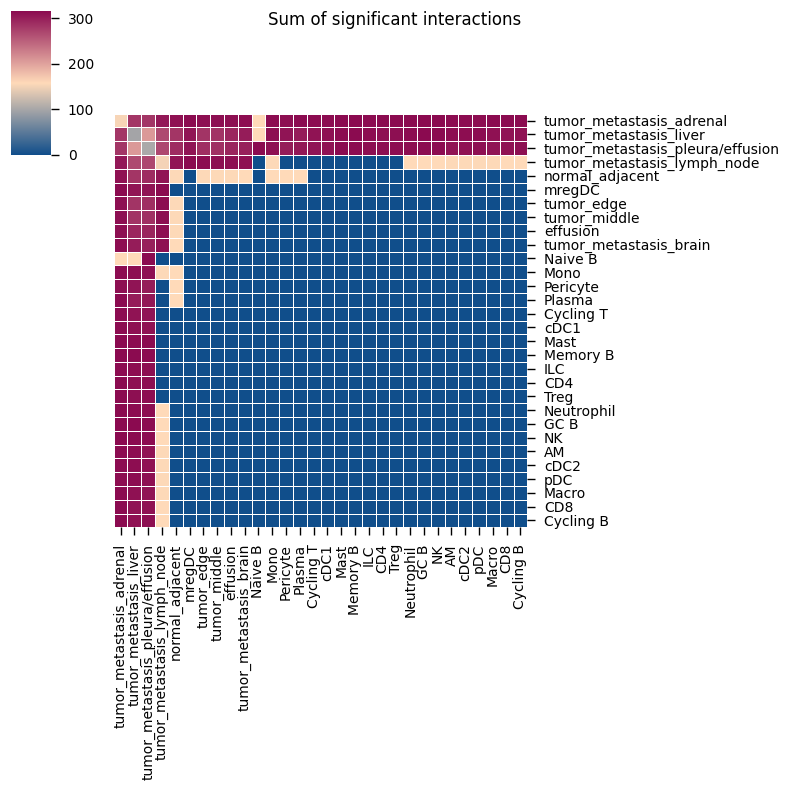

In [22]:
import ktplotspy as kpy
kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=False,
                      figsize=(8, 8),
                      title="Sum of significant interactions")

In [66]:
cpdb_results['relevant_interactions']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,tumor_metastasis_adrenal|cDC1,tumor_metastasis_adrenal|mregDC,tumor_metastasis_adrenal|pDC,tumor_metastasis_adrenal|Neutrophil,tumor_metastasis_adrenal|ILC,tumor_metastasis_adrenal|tumor_metastasis_lymph_node,tumor_metastasis_adrenal|tumor_metastasis_brain,tumor_metastasis_adrenal|tumor_metastasis_pleura/effusion,tumor_metastasis_adrenal|tumor_metastasis_liver,tumor_metastasis_adrenal|tumor_metastasis_adrenal
12,CPI-SC04BCFC59C,COL1A1_integrin_a2b1_complex,simple:P02452,complex:integrin_a2b1_complex,COL1A1,NaN,True,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
24,CPI-SC046604E76,COL4A2_integrin_a2b1_complex,simple:P08572,complex:integrin_a2b1_complex,COL4A2,NaN,True,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
41,CPI-SC0A916E0E2,COL9A2_integrin_a2b1_complex,simple:Q14055,complex:integrin_a2b1_complex,COL9A2,NaN,True,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
88,CPI-SC08DBCCFF0,COL1A1_integrin_a1b1_complex,simple:P02452,complex:integrin_a1b1_complex,COL1A1,NaN,True,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
100,CPI-SC03F728659,COL4A2_integrin_a1b1_complex,simple:P08572,complex:integrin_a1b1_complex,COL4A2,NaN,True,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,CPI-SC0ECDB073E,WNT9A_FZD3_LRP6,simple:O14904,complex:FZD3_LRP6,WNT9A,NaN,True,False,False,curated,...,0,0,0,0,0,0,0,0,0,0
2848,CPI-SS0D7DB794A,CD274_CD80,simple:Q9NZQ7,simple:P33681,CD274,CD80,False,True,True,curated,...,0,0,0,0,0,0,0,0,0,0
2849,CPI-SS09D4B2070,CD274_PDCD1,simple:Q9NZQ7,simple:Q15116,CD274,PDCD1,False,True,True,curated,...,0,0,0,0,0,0,0,0,0,0
2861,CPI-SS01999882C,CD70_CD27,simple:P32970,simple:P26842,CD70,CD27,True,False,True,curated,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cat = ['AM', 'CD4', 'CD8', 'Cycling B', 'Cycling T', 'GC B', 'ILC', 'Macro',
       'Mast', 'Memory B', 'Mono', 'NK', 'Naive B', 'Neutrophil', 'Pericyte',
       'Plasma', 'Treg', 'cDC1', 'cDC2', 'effusion', 'mregDC',
       'normal_adjacent', 'pDC', 'tumor_edge',
       'tumor_metastasis_adrenal', 'tumor_metastasis_brain',
       'tumor_metastasis_liver',
       'tumor_metastasis_lymph_node', 'tumor_metastasis_pleura/effusion',
       'tumor_middle']
kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=True,
                      log1p_transform=True,
                      cell_types=['tumor_metastasis_brain','AM', 'CD4', 'CD8', 'Treg' 'Cycling B', 'Cycling T', 
                                  'GC B', 'NK', 'Naive B','Plasma', 'ILC', 'Macro','Mast', 'Memory B', 'Mono',
                                  'Neutrophil', 'cDC1', 'cDC2','mregDC','pDC'],
                      figsize=(5,5),
                      title="Sum of significant interactions in tumor_metastasis_brain")